In [27]:
import numpy as np
import pandas as pd
from astropy.cosmology import Planck13 as cosmo
from astropy.io import fits
import fsps
from matplotlib.gridspec import GridSpec
from spec_tools import Source_present, Scale_model, Oldest_galaxy, Sig_int,Likelihood_contours, Median_w_Error_cont
from spec_extract import Scale_spectra
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from C_full_fit import Gen_spec2, Chi_Squared
from C_sim_test import Gen_sim, F_lam_per_M

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 


In [2]:
galDB = pd.read_pickle('../dataframes/galaxy_database.pkl')
BFs = pd.read_pickle('../dataframes/BF_fit_all.pkl')
lwa = np.load('../data/light_weight_scaling_3.npy')
metal=np.round(np.arange(0.002,0.031,0.001),3)
age=np.round(np.arange(.5,6.1,.1),1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
dust = np.arange(0,1.1,.1)
M,A=np.meshgrid(metal,age)

In [30]:
idx = 22

# sp = fsps.StellarPopulation(imf_type = 0, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(0.019/0.019), sfh = 4, tau = 0.1)
wave, flux = sp.get_spectrum(tage = 2.3, peraa = True)


In [134]:
updtau = np.round(np.logspace(-2,np.log10(3),20),3)
updage = np.round(np.arange(0.1,np.round(Oldest_galaxy(1.6),1) + .05,.05),2)
updmetal=np.round(np.arange(0.002,0.0305,0.0005),4)
upddust = np.arange(0,1.05,.05)


In [14]:
sim1 = Gen_sim(galDB.field[idx], galDB.ids[idx], 1.6074, glob('../beams/*{0}*.g102.A.fits'.format(galDB.ids[idx]))[0],
              glob('../beams/*{0}*.g141.A.fits'.format(galDB.ids[idx]))[0],wave,flux, sp.stellar_mass,
            g102_lims = [7500,12000],g141_lims = [10500,18000],tmp_err=False, phot_errterm=0.03)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


In [39]:
f_lam = F_lam_per_M(flux, wave*(1+1.6074), 1.6074, 0, sp.stellar_mass)    
    
Pmfl = sim1.Sim_phot_mult(wave * (1 + 1.6074), f_lam)
mass =  Scale_model(sim1.Pflx, sim1.Perr, Pmfl)  
Pmfl = Pmfl * mass

In [41]:
np.log10(mass)

11.195866675106013

In [45]:
[Bmw, Bmf], [Rmw, Rmf] = sim1.Sim_spec_mult(wave * (1 + 1.6074), 
                                            f_lam*mass)
iBmf = interp1d(Bmw,Bmf)(sim1.Bwv)       
iRmf = interp1d(Rmw,Rmf)(sim1.Rwv)  

BC = Scale_model(sim1.Bflx * sim1.Bflt,sim1.Berr * sim1.Bflt, iBmf)
RC = Scale_model(sim1.Rflx * sim1.Rflt,sim1.Rerr * sim1.Rflt, iRmf)

<ErrorbarContainer object of 3 artists>

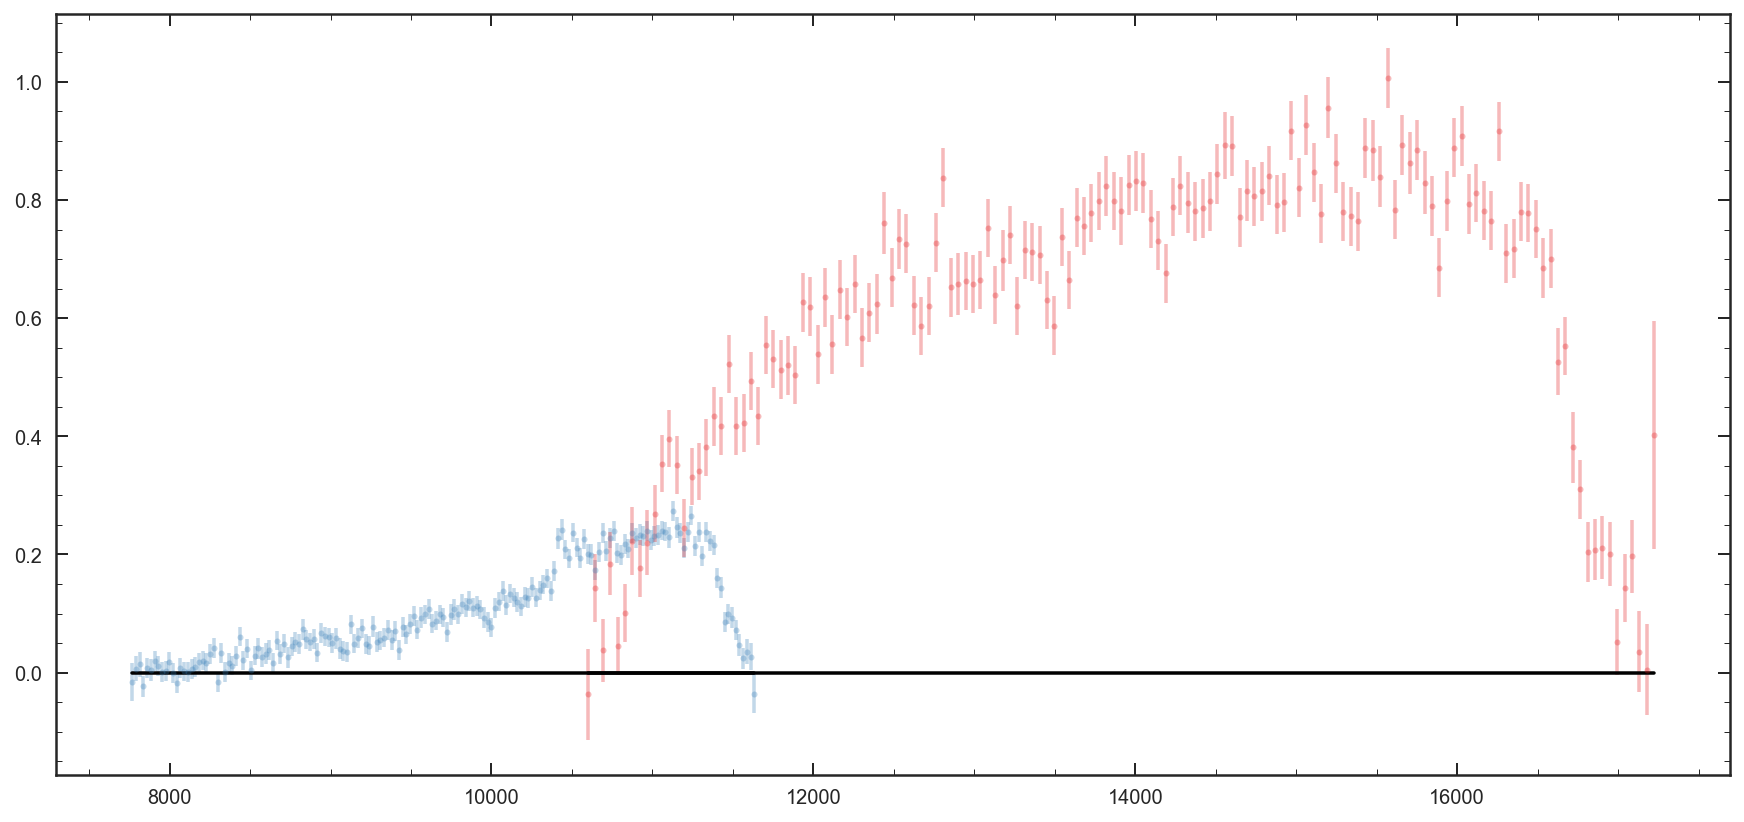

In [47]:
plt.figure(figsize=[15,7])
plt.plot(sim1.Bwv, iBmf,color='k')
plt.plot(sim1.Rwv, iRmf, color='k')

plt.errorbar(sim1.Bwv, sim1.Bflx * sim1.Bflt, sim1.Berr * sim1.Bflt,
                        linestyle='None', marker='o', markersize=3, color='#377eb8', alpha=.3)

plt.errorbar(sim1.Rwv, sim1.Rflx * sim1.Rflt,sim1.Rerr * sim1.Rflt, 
            linestyle='None', marker='o', markersize=3, color='#e41a1c', alpha=.3)

# plt.xlim(8000,17000)
# plt.ylim(0, 0.25E-18)


In [23]:
print(Chi_Squared(sim1.Bflx * sim1.Bflt,BC*iBmf ,sim1.Berr * sim1.Bflt))
print(Chi_Squared(sim1.Rflx * sim1.Rflt,RC*iRmf ,sim1.Rerr * sim1.Rflt))

168.4018699542625
180.87570325127564


In [24]:
Bmfl = iBmf / sim1.Btrans
Rmfl = iRmf / sim1.Rtrans

BC2 = Scale_model(sim1.Bflx,sim1.Berr, Bmfl)
RC2 = Scale_model(sim1.Rflx,sim1.Rerr, Rmfl)

print(Chi_Squared(sim1.Bflx,BC2*Bmfl ,sim1.Berr))
print(Chi_Squared(sim1.Rflx,RC2*Rmfl ,sim1.Rerr))

168.96593813300558
187.18722953016646


(-2e-18, 2e-18)

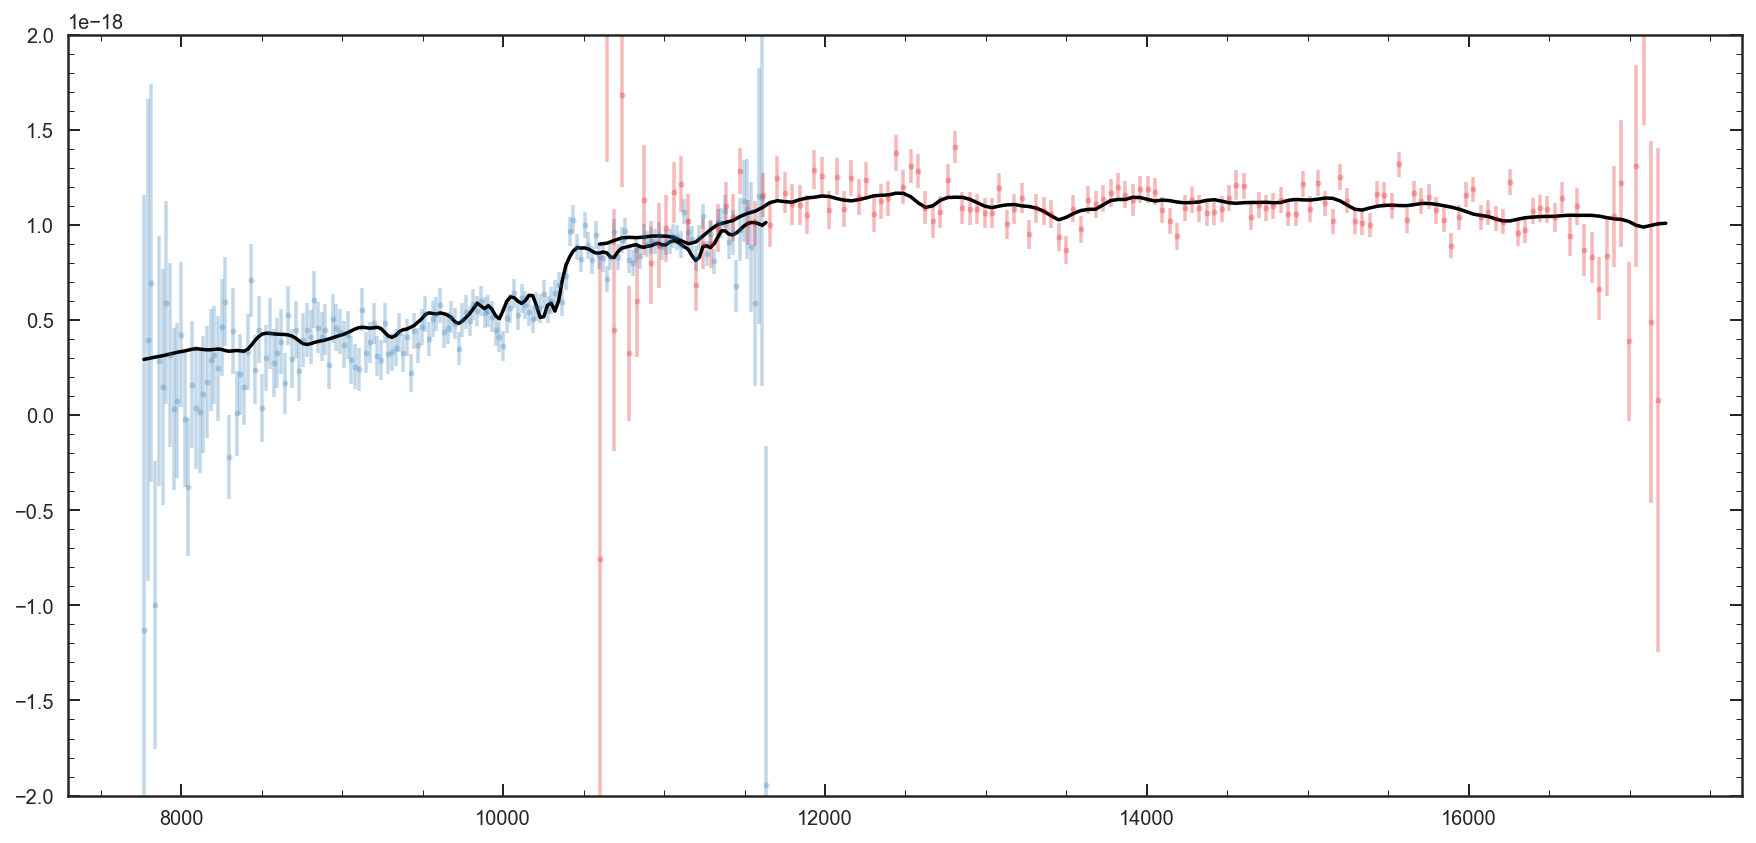

In [26]:
plt.figure(figsize=[15,7])
plt.plot(sim1.Bwv, BC2*Bmfl,color='k')
plt.plot(sim1.Rwv, RC2*Rmfl, color='k')

plt.errorbar(sim1.Bwv, sim1.Bflx, sim1.Berr,
                        linestyle='None', marker='o', markersize=3, color='#377eb8', alpha=.3)

plt.errorbar(sim1.Rwv, sim1.Rflx ,sim1.Rerr , 
            linestyle='None', marker='o', markersize=3, color='#e41a1c', alpha=.3)
plt.ylim(-0.2E-17,0.2E-17)

<ErrorbarContainer object of 3 artists>

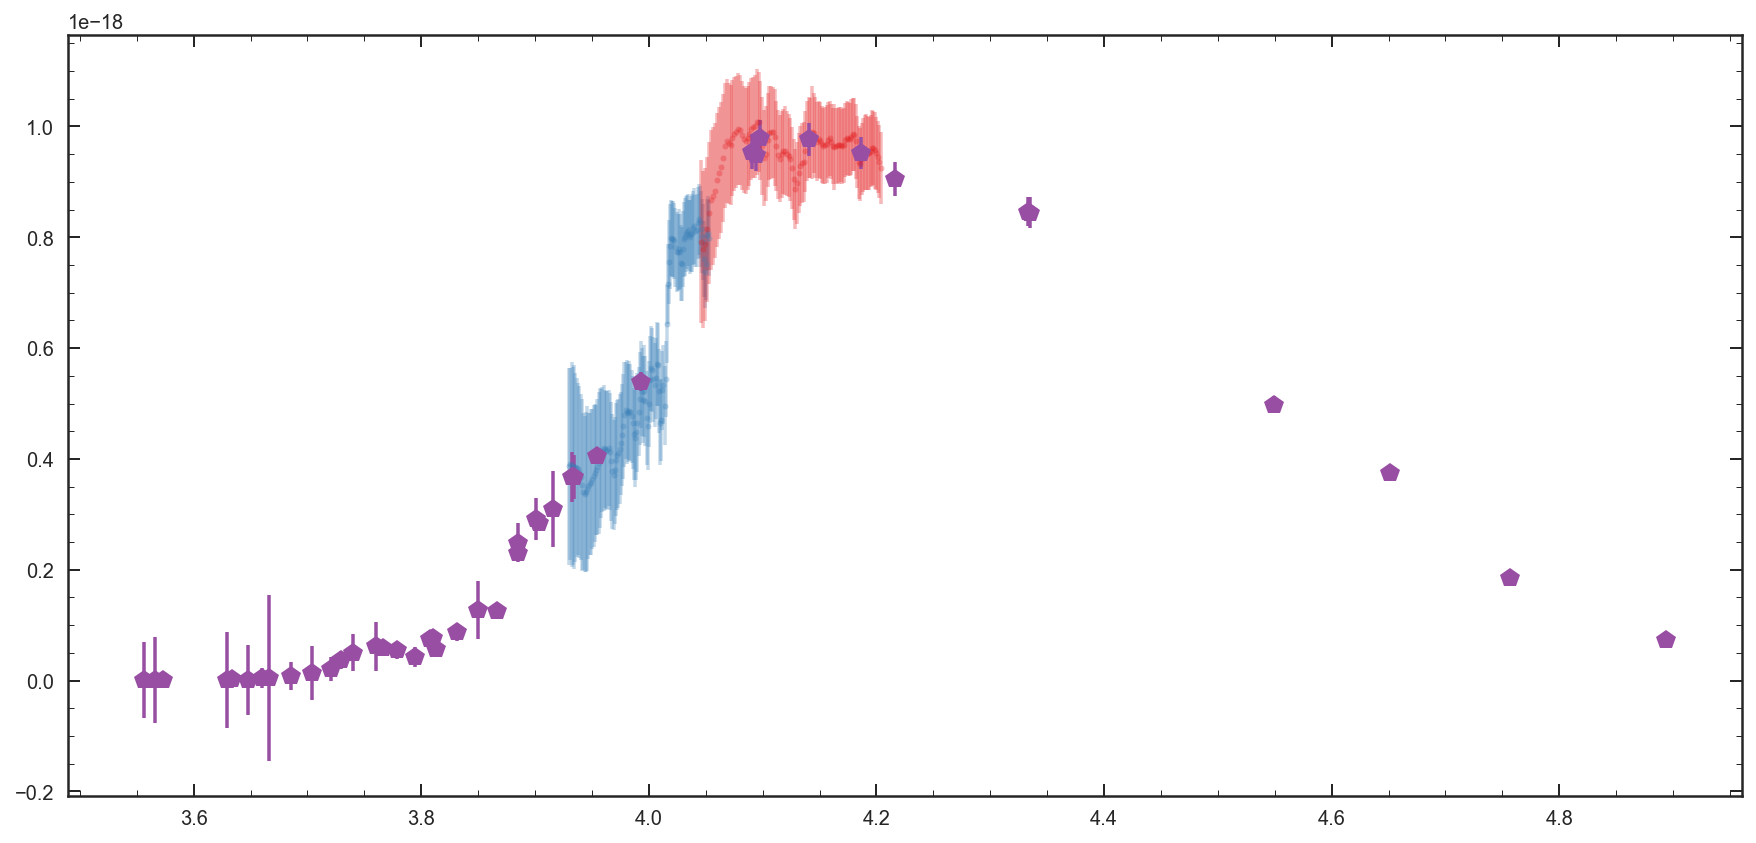

In [6]:
plt.figure(figsize=[15,7])

plt.errorbar(np.log10(sim1.Bwv), sim1.SBflx, sim1.SBer,
                             linestyle='None', marker='o', markersize=3, color='#377eb8', alpha=.3)
plt.errorbar(np.log10(sim1.Rwv), sim1.SRflx, sim1.SRer,
            linestyle='None', marker='o', markersize=3, color='#e41a1c', alpha=.3)
plt.errorbar(np.log10(sim1.Pwv), sim1.SPflx, sim1.SPer,
                             linestyle='None', marker='p', markersize=10, color='#984ea3')
# plt.ylim(0,0.2E-17)



<ErrorbarContainer object of 3 artists>

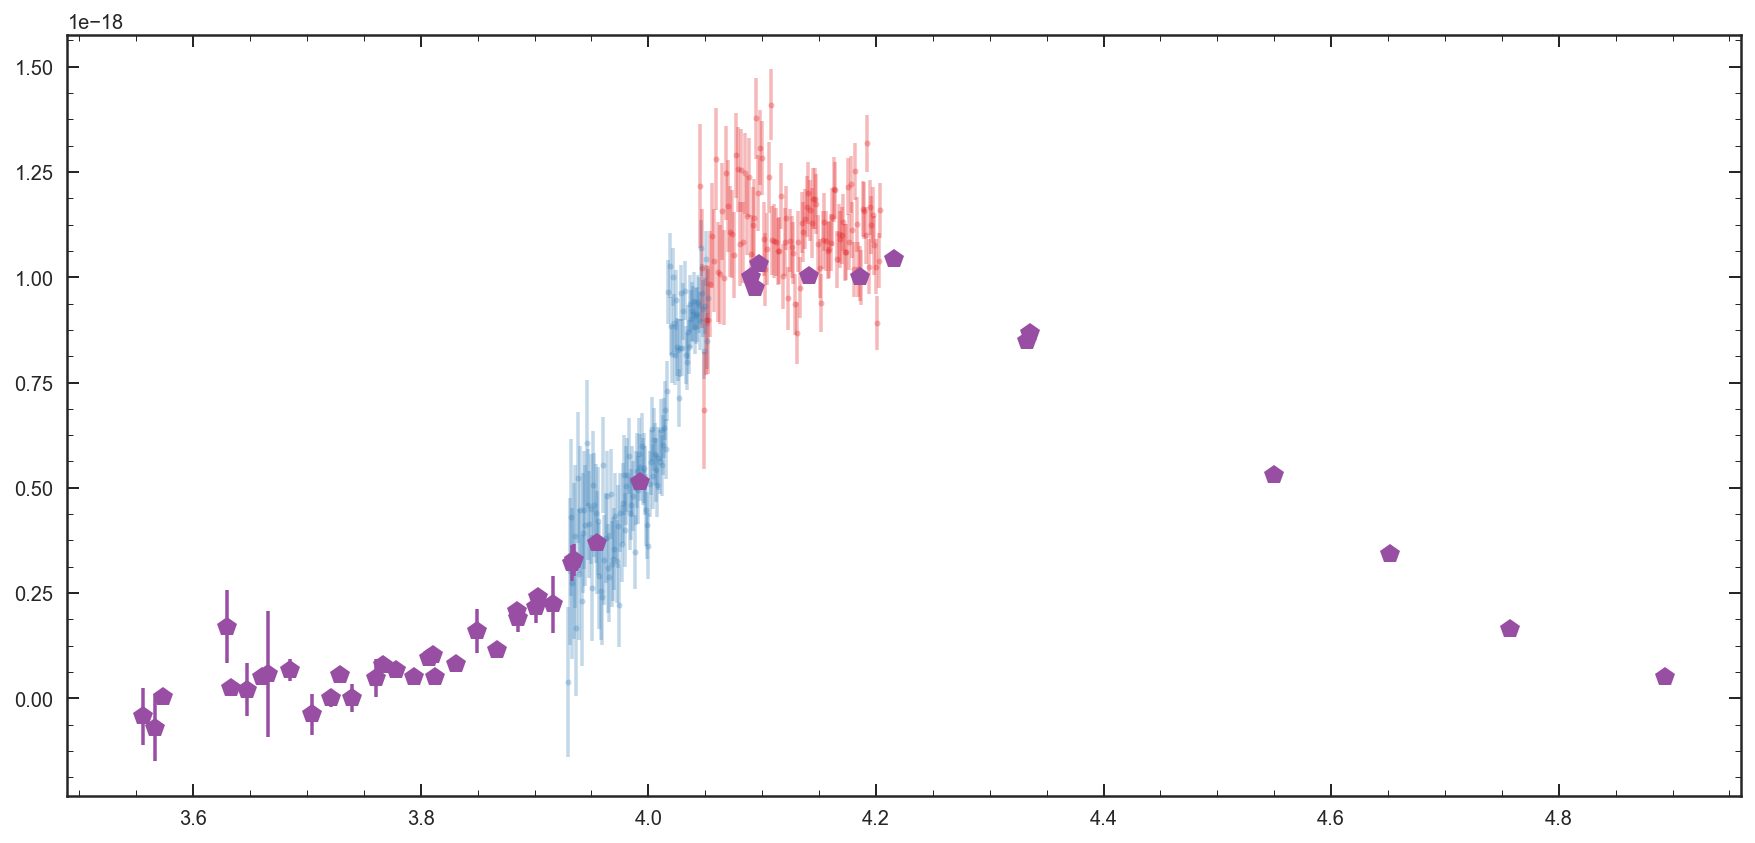

In [5]:
plt.figure(figsize=[15,7])

plt.errorbar(np.log10(sim1.Bwv), sim1.Bflx, sim1.Berr,
                             linestyle='None', marker='o', markersize=3, color='#377eb8', alpha=.3)
plt.errorbar(np.log10(sim1.Rwv), sim1.Rflx, sim1.Rerr,
            linestyle='None', marker='o', markersize=3, color='#e41a1c', alpha=.3)
plt.errorbar(np.log10(sim1.Pwv), sim1.Pflx, sim1.Perr,
                             linestyle='None', marker='p', markersize=10, color='#984ea3')


In [7]:
sim1.lmass

10.780375372508123

In [266]:
sp = fsps.StellarPopulation(imf_type = 0, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(0.0186/0.019), sfh = 4, tau = 0.095)
wave, flux = sp.get_spectrum(tage = 2.254, peraa = True)

sim1 = Gen_sim(galDB.field[idx], galDB.ids[idx], galDB.z_grism[idx], glob('../beams/*{0}*.g102.A.fits'.format(galDB.ids[idx]))[0],
              glob('../beams/*{0}*.g141.A.fits'.format(galDB.ids[idx]))[0],wave,flux,11,sp.stellar_mass,
              g102_lims=[8500,11300],tmp_err=True, phot_errterm=0.03, offset=True, offset_limit=0.5 )

In [41]:
def P(F,x):
    F = np.array(F).astype(np.float128)
    return np.exp(-np.array(F) / 2) / np.trapz(np.exp(-np.array(F) / 2),x)

(3, 5)

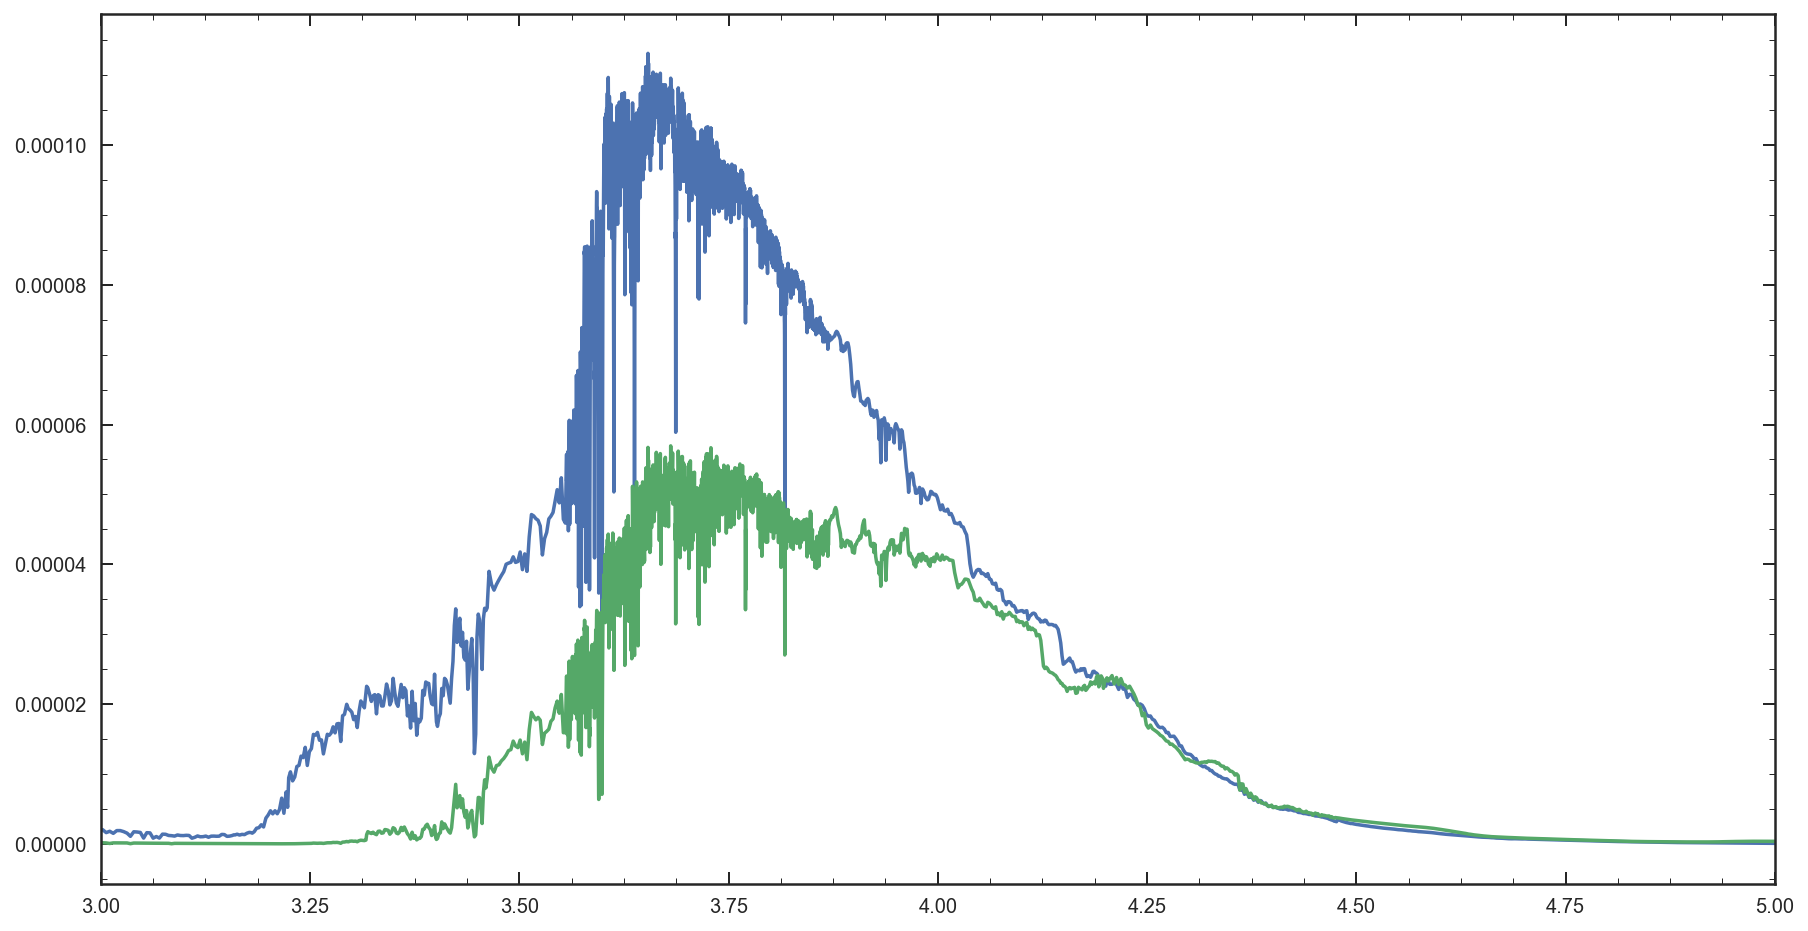

In [347]:
plt.figure(figsize=[15,8])
wv,fl = np.load('/Users/Vince.ec/fsps_models_for_fit/fsps_spec/m0.002_a2.3_dt8.0_spec.npy')
plt.plot(np.log10(wv),fl)
wv,fl = np.load('/Users/Vince.ec/fsps_models_for_fit/fsps_spec/m0.03_a2.3_dt8.0_spec.npy')
plt.plot(np.log10(wv),fl)             
plt.xlim(3,5)

In [ ]:
def Fit_all_sim(field, galaxy, g102_beam, g141_beam, specz, metal, age, tau, rshift, dust, 
                simZ, simt, simtau, simz, simd, name, gen_models = True, 
                age_conv= data_path + 'light_weight_scaling_3.npy', errterm = 0,
           outname = 'none'):
   
    if outname == 'none':
        outname = name
    ######## initialize spec
    
    sp = fsps.StellarPopulation(imf_type = 0, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(simZ/0.019), sfh = 4, tau = simtau)
    wave, flux = sp.get_spectrum(tage = simt, peraa = True)

    sim1 = Gen_sim(field, galaxy, specz, g102_beam, g141_beam,
                   wave, flux, 11, sp.stellar_mass, g102_lims=[8500,11300], 
                   tmp_err=True, phot_errterm = errterm, offset=True, offset_limit=0.5 )    
    if gen_models:
        Gen_mflgrid(sp, name, metal, age, tau, rshift)

    ## set some variables
    wv,fl = np.load(model_path + 'm0.019_a2.0_dt8.0_spec.npy')
    [Bmwv,Bmflx], [Rmwv,Rmflx] = sp.Sim_spec_mult(wv,fl)
    
    Stitch_resize_redden_fit2(sp.Pwv, sp.SPflx, sp.SPer, 'none', 'phot', name, sp.Pwv, 
                     metal, age, tau, rshift, outname, phot = True) 
    
    Stitch_resize_redden_fit2(sp.Bwv, sp.SBflx, sp.SBer, sp.Btrans, 'g102', name, Bmwv, 
                     metal, age, tau, rshift, outname)
    Stitch_resize_redden_fit2(sp.Rwv, sp.SRflx, sp.SRer, sp.Rtrans, 'g141', name, Rmwv, 
                     metal, age, tau, rshift, outname)

    P, PZ, Pt, Ptau, Pz, Pd = Analyze_full_fit(outname, metal, age, tau, rshift, 
                                               dust=dust,age_conv = age_conv)

    np.save(out_path + '{0}_tZ_sim_pos'.format(outname),P)
    np.save(out_path + '{0}_Z_sim_pos'.format(outname),[metal,PZ])
    np.save(out_path + '{0}_t_sim_pos'.format(outname),[age,Pt])
    np.save(out_path + '{0}_tau_sim_pos'.format(outname),[np.append(0, np.power(10, np.array(tau)[1:] - 9)),Ptau])
    np.save(out_path + '{0}_rs_sim_pos'.format(outname),[rshift,Pz])
    np.save(out_path + '{0}_d_sim_pos'.format(outname),[dust,Pd])

In [9]:
Z,PZ = np.load('../data/posteriors/sim_fit_GSD_41520_Z_sim_pos.npy')
t,Pt = np.load('../data/posteriors/sim_fit_GSD_41520_t_sim_pos.npy')
ult,Ptau = np.load('../data/posteriors/sim_fit_GSD_41520_tau_sim_pos.npy')
d,Pd = np.load('../data/posteriors/sim_fit_GSD_41520_d_sim_pos.npy')

Z,PZfs = np.load('../data/posteriors/sim_fit_GSD_41520_Z_sim_pos_fs.npy')
t,Ptfs = np.load('../data/posteriors/sim_fit_GSD_41520_t_sim_pos_fs.npy')
ult,Ptaufs = np.load('../data/posteriors/sim_fit_GSD_41520_tau_sim_pos_fs.npy')
d,Pdfs = np.load('../data/posteriors/sim_fit_GSD_41520_d_sim_pos_fs.npy')

Z,BPZ = np.load('../data/posteriors/sim_fit_GSD_41520_Z_g102_pos.npy')
t,BPt = np.load('../data/posteriors/sim_fit_GSD_41520_t_g102_pos.npy')
ult,BPtau = np.load('../data/posteriors/sim_fit_GSD_41520_tau_g102_pos.npy')
d,BPd = np.load('../data/posteriors/sim_fit_GSD_41520_d_g102_pos.npy')

Z,RPZ = np.load('../data/posteriors/sim_fit_GSD_41520_Z_g141_pos.npy')
t,RPt = np.load('../data/posteriors/sim_fit_GSD_41520_t_g141_pos.npy')
ult,RPtau = np.load('../data/posteriors/sim_fit_GSD_41520_tau_g141_pos.npy')
d,RPd = np.load('../data/posteriors/sim_fit_GSD_41520_d_g141_pos.npy')

Z,PPZ = np.load('../data/posteriors/sim_fit_GSD_41520_Z_phot_pos.npy')
t,PPt = np.load('../data/posteriors/sim_fit_GSD_41520_t_phot_pos.npy')
ult,PPtau = np.load('../data/posteriors/sim_fit_GSD_41520_tau_phot_pos.npy')
d,PPd = np.load('../data/posteriors/sim_fit_GSD_41520_d_phot_pos.npy')

Z,GPZ = np.load('../data/posteriors/sim_fit_GSD_41520_Z_grism_pos.npy')
t,GPt = np.load('../data/posteriors/sim_fit_GSD_41520_t_grism_pos.npy')
ult,GPtau = np.load('../data/posteriors/sim_fit_GSD_41520_tau_grism_pos.npy')
d,GPd = np.load('../data/posteriors/sim_fit_GSD_41520_d_grism_pos.npy')


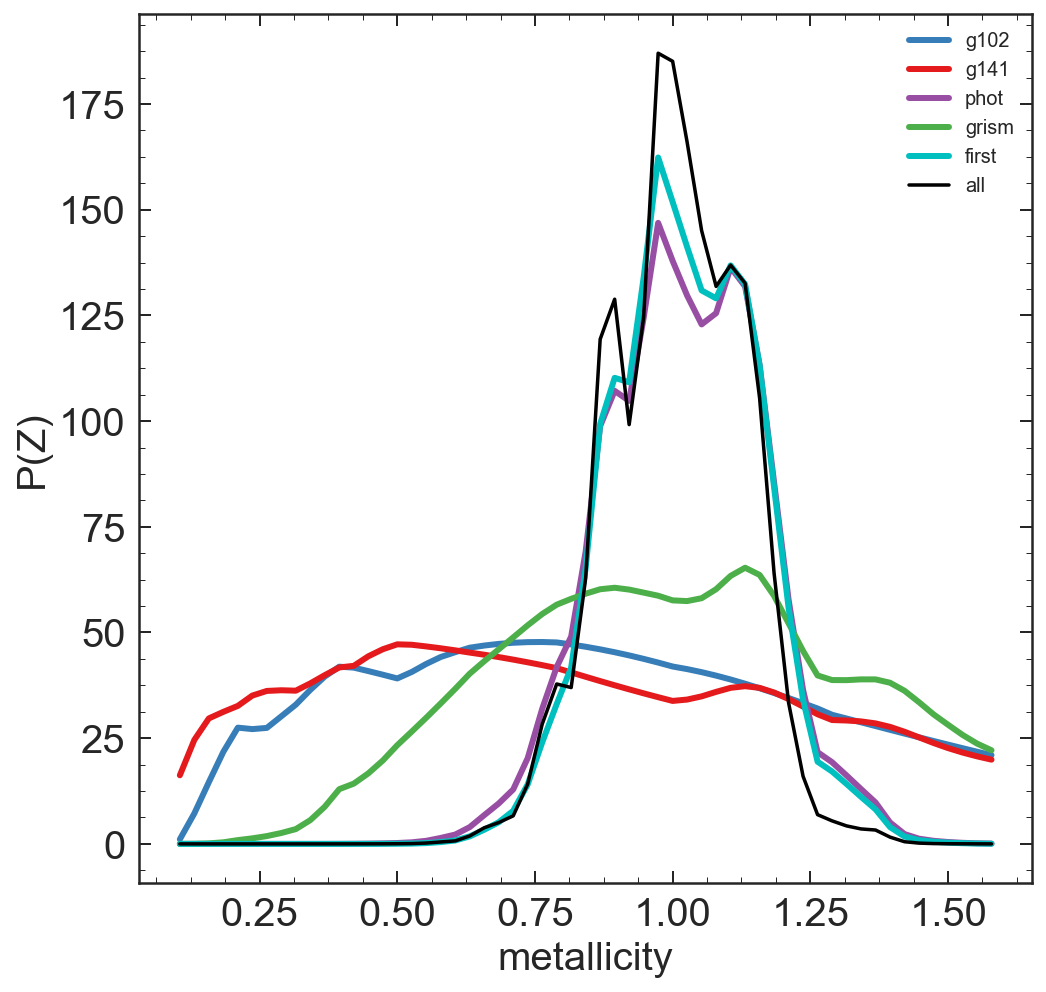

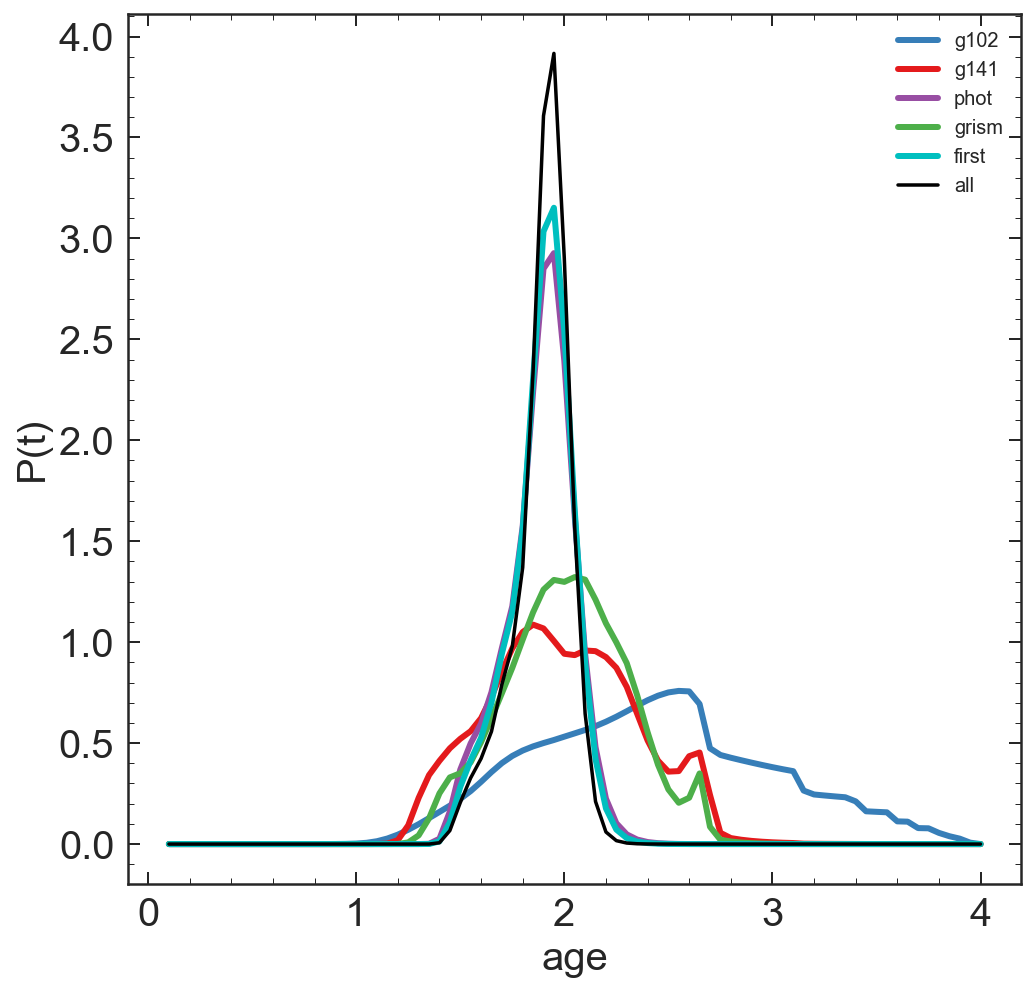

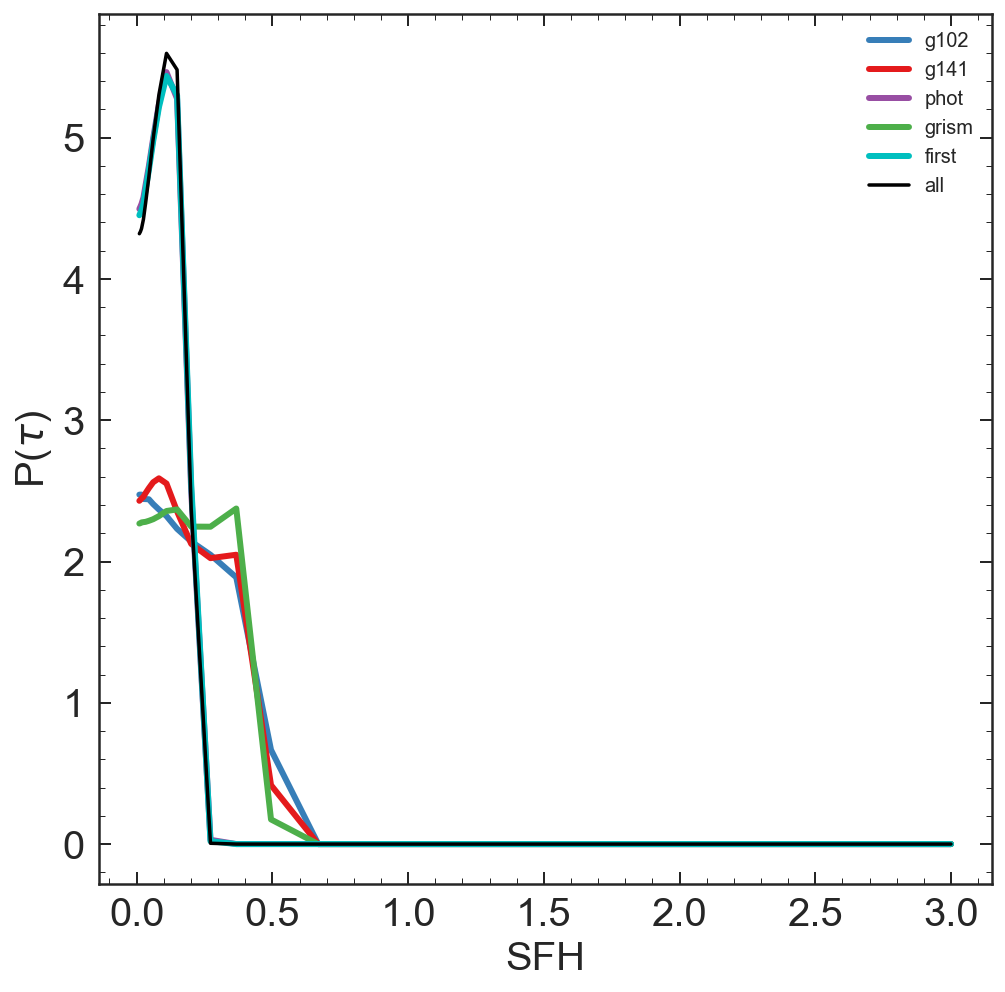

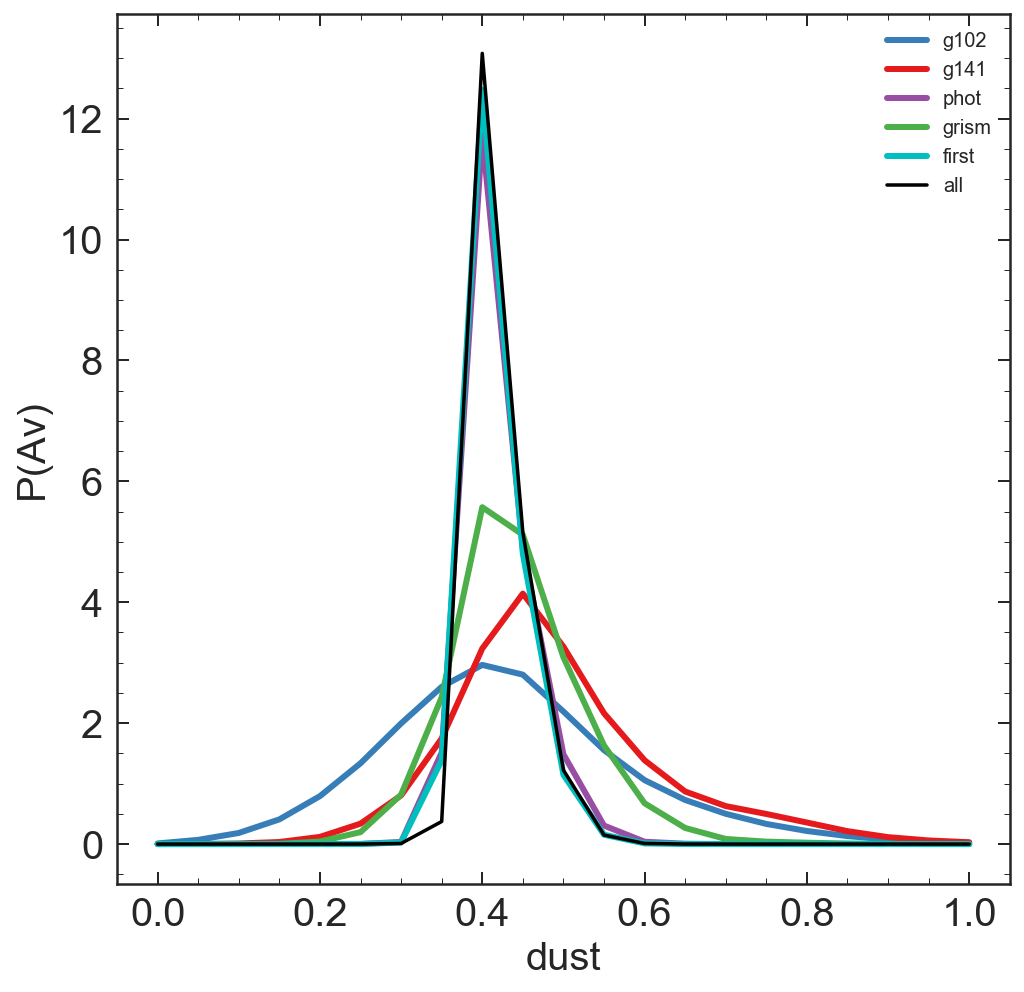

In [10]:
plt.figure(figsize=[8,8])
plt.plot(Z/0.019 ,BPZ, linewidth = 3, color='#377eb8', label = 'g102')
plt.plot(Z/0.019 ,RPZ, linewidth = 3, color='#e41a1c', label = 'g141')
plt.plot(Z/0.019 ,PPZ, linewidth = 3, color='#984ea3', label = 'phot')
plt.plot(Z/0.019 ,GPZ, linewidth = 3, color='#4daf4a', label = 'grism')
plt.plot(Z/0.019 ,PZfs, linewidth = 3, color='c', label = 'first')
plt.plot(Z/0.019 ,PZ, color='k', label = 'all')
plt.xlabel('metallicity', fontsize=20)
plt.ylabel('P(Z)', fontsize=20)
plt.legend()
plt.tick_params(axis='both', which='major', labelsize=20)

plt.figure(figsize=[8,8])
plt.plot(t ,BPt, linewidth = 3, color='#377eb8', label = 'g102')
plt.plot(t ,RPt, linewidth = 3, color='#e41a1c', label = 'g141')
plt.plot(t ,PPt, linewidth = 3, color='#984ea3', label = 'phot')
plt.plot(t ,GPt, linewidth = 3, color='#4daf4a', label = 'grism')
plt.plot(t ,Ptfs, linewidth = 3, color='c', label = 'first')
plt.plot(t ,Pt, color='k', label = 'all')
plt.xlabel('age', fontsize=20)
plt.ylabel('P(t)', fontsize=20)
plt.legend()
plt.tick_params(axis='both', which='major', labelsize=20)

plt.figure(figsize=[8,8])
plt.plot(ult ,BPtau, linewidth = 3, color='#377eb8', label = 'g102')
plt.plot(ult ,RPtau, linewidth = 3, color='#e41a1c', label = 'g141')
plt.plot(ult ,PPtau, linewidth = 3, color='#984ea3', label = 'phot')
plt.plot(ult ,GPtau, linewidth = 3, color='#4daf4a', label = 'grism')
plt.plot(ult ,Ptaufs, linewidth = 3, color='c', label = 'first')
plt.plot(ult ,Ptau, color='k', label = 'all')
plt.xlabel('SFH', fontsize=20)
plt.ylabel('P($\\tau$)', fontsize=20)
plt.legend()
plt.tick_params(axis='both', which='major', labelsize=20)

plt.figure(figsize=[8,8])
plt.plot(d ,BPd, linewidth = 3, color='#377eb8', label = 'g102')
plt.plot(d ,RPd, linewidth = 3, color='#e41a1c', label = 'g141')
plt.plot(d ,PPd, linewidth = 3, color='#984ea3', label = 'phot')
plt.plot(d ,GPd, linewidth = 3, color='#4daf4a', label = 'grism')
plt.plot(d ,Pdfs, linewidth = 3, color='c', label = 'first')
plt.plot(d ,Pd, color='k', label = 'all')
plt.xlabel('dust', fontsize=20)
plt.ylabel('P(Av)', fontsize=20)
plt.legend()
plt.tick_params(axis='both', which='major', labelsize=20)

In [18]:
LWA = lwa[metal == 0.019].T[np.array(tau) == 8.0][0].T[0].T

In [21]:
LWA[17]

1.9965257677745714

# def salmon dust law

calzetti: $A'(\lambda)=E(B−V)k'(\lambda)$

salmon: $A(\lambda,\delta) = E(B−V) k(\lambda)(\lambda/\lambda_V)^\delta$

calzetti: $10^{-0.4 k(\lambda)A_v/R_v}$

salmon: $10^{-0.4 k(\lambda)(\lambda/\lambda_V)^\delta A_v/R_v}$

$\delta = (0.62) log(E(B − V )) + 0.26$

In [70]:
def Calzetti_low(Av,lam):
    lam = lam * 1E-4
    Rv = 4.05
    k = 2.659*(-2.156 +1.509/(lam) -0.198/(lam**2) +0.011/(lam**3)) + Rv
    cal = 10**(-0.4*k*Av/Rv)
    return cal

def Calzetti_hi(Av,lam):
    lam = lam * 1E-4
    Rv=4.05
    k = 2.659*(-1.857 +1.04/(lam)) + Rv
    cal = 10**(-0.4*k*Av/Rv)    
    
    return cal

def Calzetti(Av,lam):
    dust = Calzetti_low(Av,lam)
    dust2 = Calzetti_hi(Av,lam)
    
    for ii in range(len(dust)):
        if lam[ii] > 6300:
            dust[ii]=dust2[ii] 
    return dust

def C_k_low(lam):
    lam = lam * 1E-4
    Rv = 4.05
    return 2.659*(-2.156 +1.509/(lam) -0.198/(lam**2) +0.011/(lam**3)) + Rv 

def C_k_hi(lam):
    lam = lam * 1E-4
    Rv=4.05
    return 2.659*(-1.857 +1.04/(lam)) + Rv

def C_k(lam):
    dust = C_k_low(lam)
    dust2 = C_k_hi(lam)
    
    for ii in range(len(dust)):
        if lam[ii] > 6300:
            dust[ii]=dust2[ii] 
    return dust

def Salmon_low(Av,lam):
    lam = lam * 1E-4
    lamv = 5510 * 1E-4
    Rv=4.05
    delta = 0.62 * np.log10(Av/Rv) + 0.26
    k = 2.659*(-2.156 +1.509/(lam) -0.198/(lam**2) +0.011/(lam**3)) + Rv
    cal = 10**(-0.4*k*(lam / lamv)**(delta)*Av/Rv)
    return cal

def Salmon_hi(Av,lam):
    lam = lam * 1E-4
    lamv = 5510 * 1E-4
    Rv=4.05
    delta = 0.62 * np.log10(Av/Rv) + 0.26
    k = 2.659*(-1.857 +1.04/(lam)) + Rv
    cal = 10**(-0.4*k*(lam / lamv)**(delta)*Av/Rv)    
    
    return cal

def Salmon(Av,lam):
    dust = Salmon_low(Av,lam)
    dust2 = Salmon_hi(Av,lam)
    
    for ii in range(len(dust)):
        if lam[ii] > 6300:
            dust[ii]=dust2[ii] 
    if Av == 0:
        dust = np.ones(len(dust))
    return dust

def S_k_low(lam, delta):
    lam = lam * 1E-4
    lamv = 5510 * 1E-4
    Rv=4.05
    k = 2.659*(-2.156 +1.509/(lam) -0.198/(lam**2) +0.011/(lam**3)) + Rv
    return k*(lam / lamv)**(delta)

def S_k_hi(lam, delta):
    lam = lam * 1E-4
    lamv = 5510 * 1E-4
    Rv=4.05
    k = 2.659*(-1.857 +1.04/(lam)) + Rv    
    return k*(lam / lamv)**(delta)

def S_k(lam,delta):
    dust = S_k_low(lam,delta)
    dust2 = S_k_hi(lam,delta)
    
    for ii in range(len(dust)):
        if lam[ii] > 6300:
            dust[ii]=dust2[ii] 
    
    return dust

In [41]:
cal = Calzetti(1,wave)
sal = Salmon(1,wave)

(2, 6)

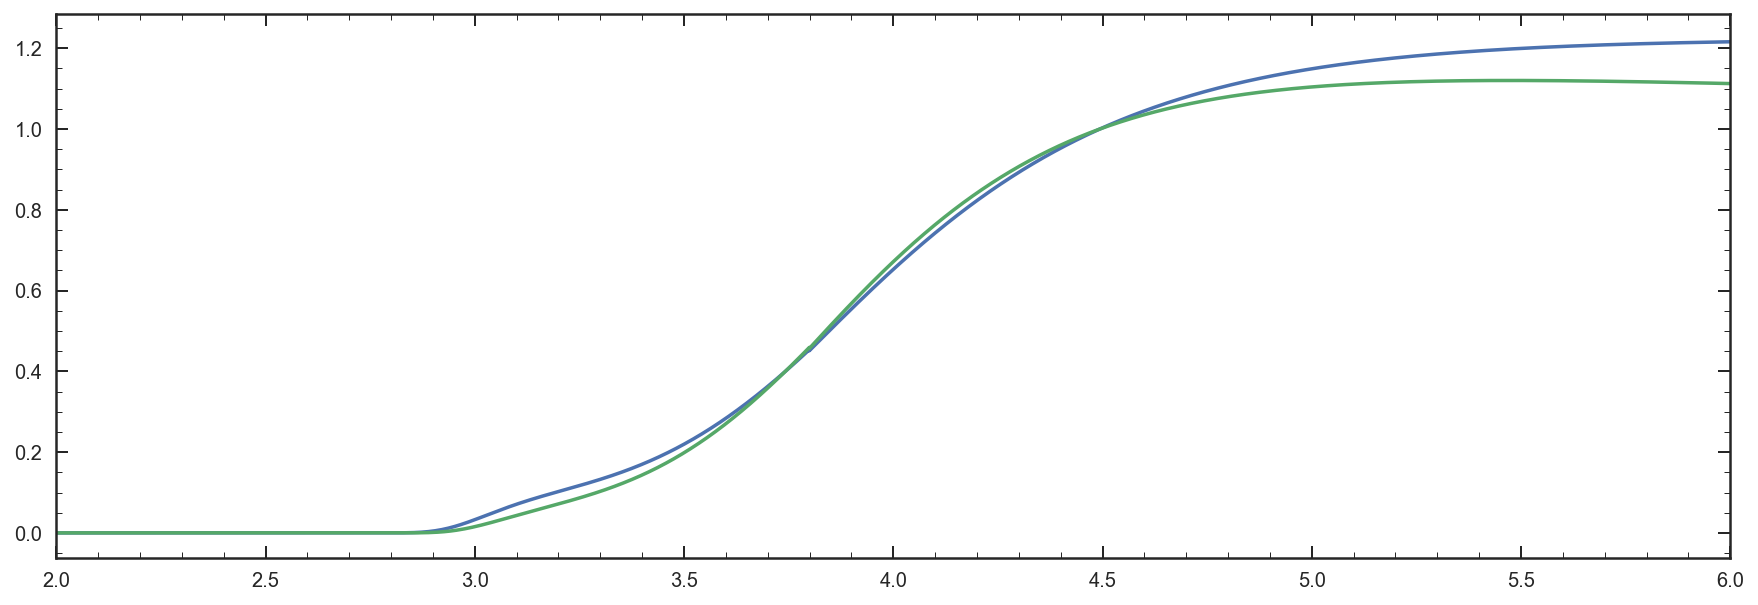

In [42]:
plt.figure(figsize=[15,5])
plt.plot(np.log10(wave),cal)
plt.plot(np.log10(wave),sal)
plt.xlim(2,6)

In [73]:
7900 / 3.5, 16000 / 1.9

(2257.1428571428573, 8421.052631578948)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log10
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in multiply
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in log10
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in multiply


(3.3521825181113627, 3.9253120914996495)

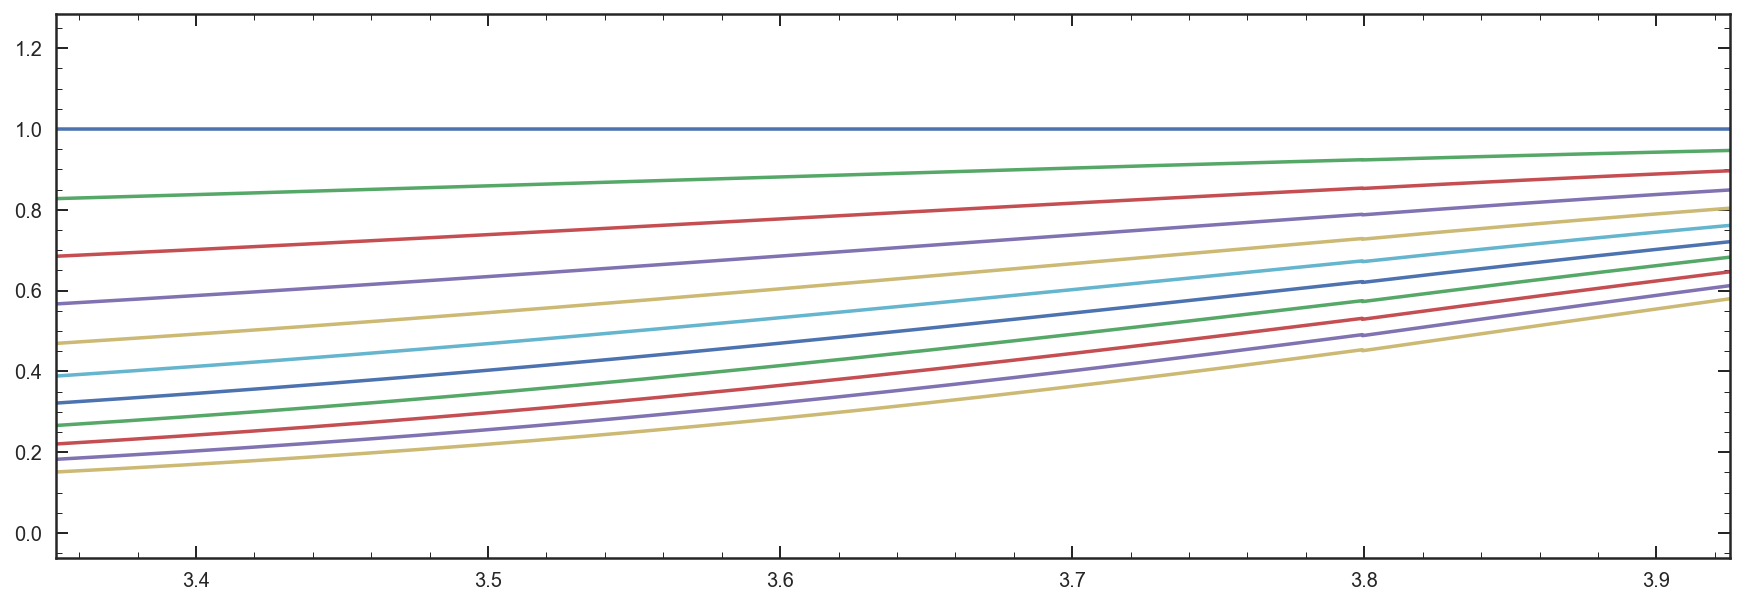

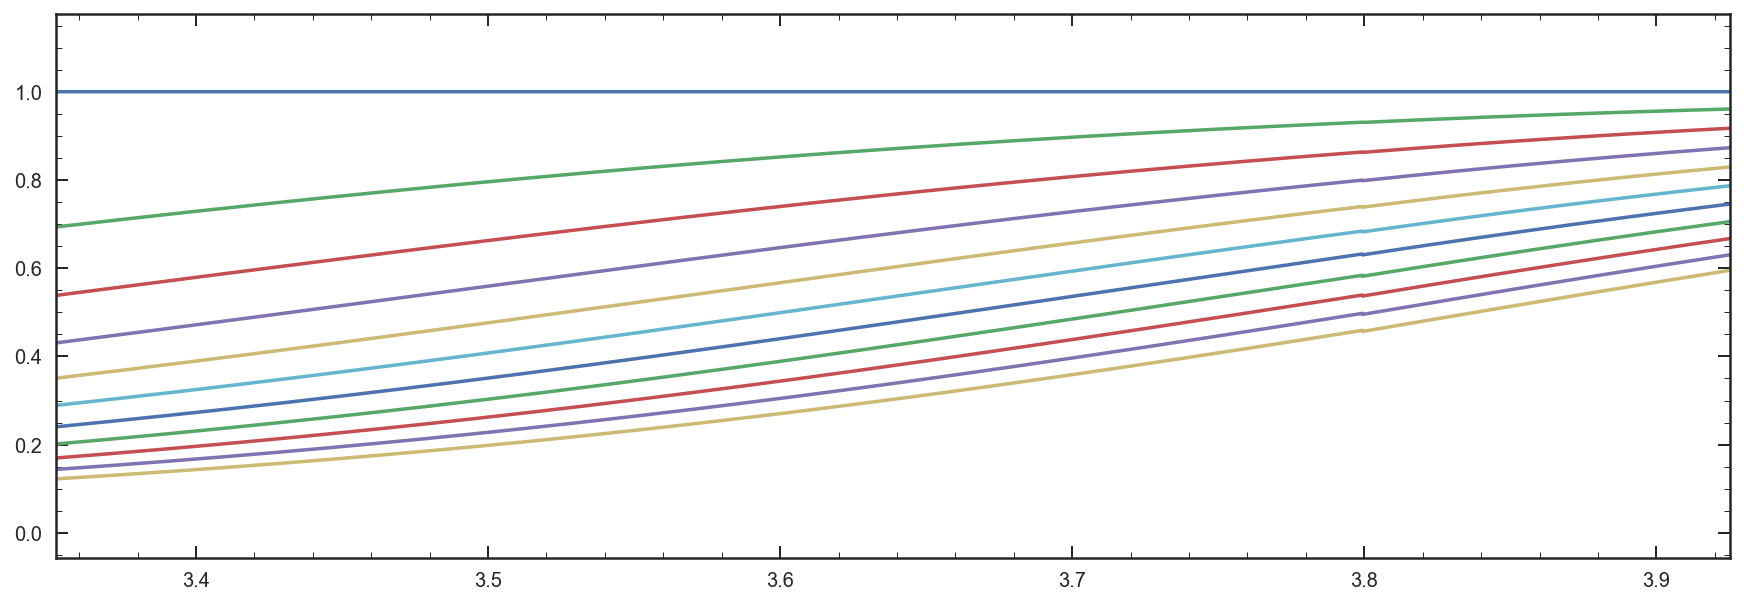

In [75]:
plt.figure(figsize=[15,5])

for i in np.arange(0,1.1,0.1):
    plt.plot(np.log10(wave), Calzetti(i,wave))
plt.xlim(np.log10(2250),np.log10(8420))

plt.figure(figsize=[15,5])

for i in np.arange(0,1.1,0.1):
    plt.plot(np.log10(wave), Salmon(i,wave))
plt.xlim(np.log10(2250),np.log10(8420))


In [69]:
Salmon(0,wave)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log10
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in multiply
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in log10
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in multiply


array([nan, nan, nan, ...,  1.,  1.,  1.])

In [65]:
Av = np.arange(0,3,0.1)
Rv=4.05
delta = 0.62 * np.log10(Av/Rv) + 0.26
ebv = Av / Rv

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


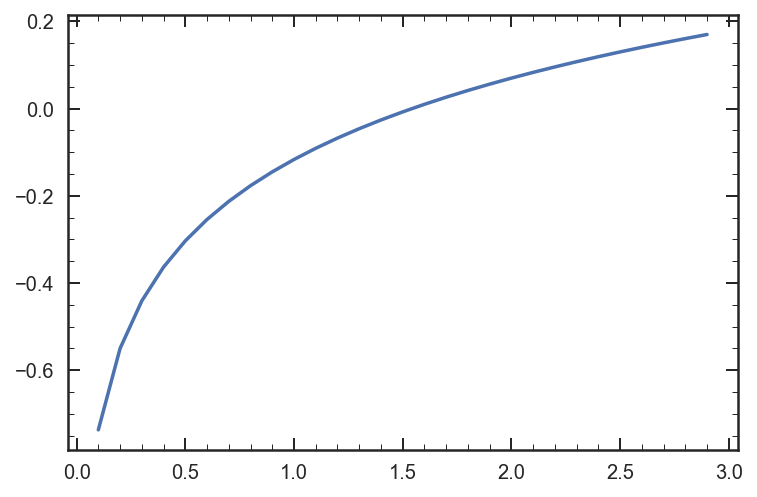

In [67]:
plt.plot(Av, delta)
# plt.xlim(0,0.7)
# plt.ylim(-0.65,0.55)

In [50]:
ck = C_k(wave)
sk = S_k(wave,0)

(-1, 20)

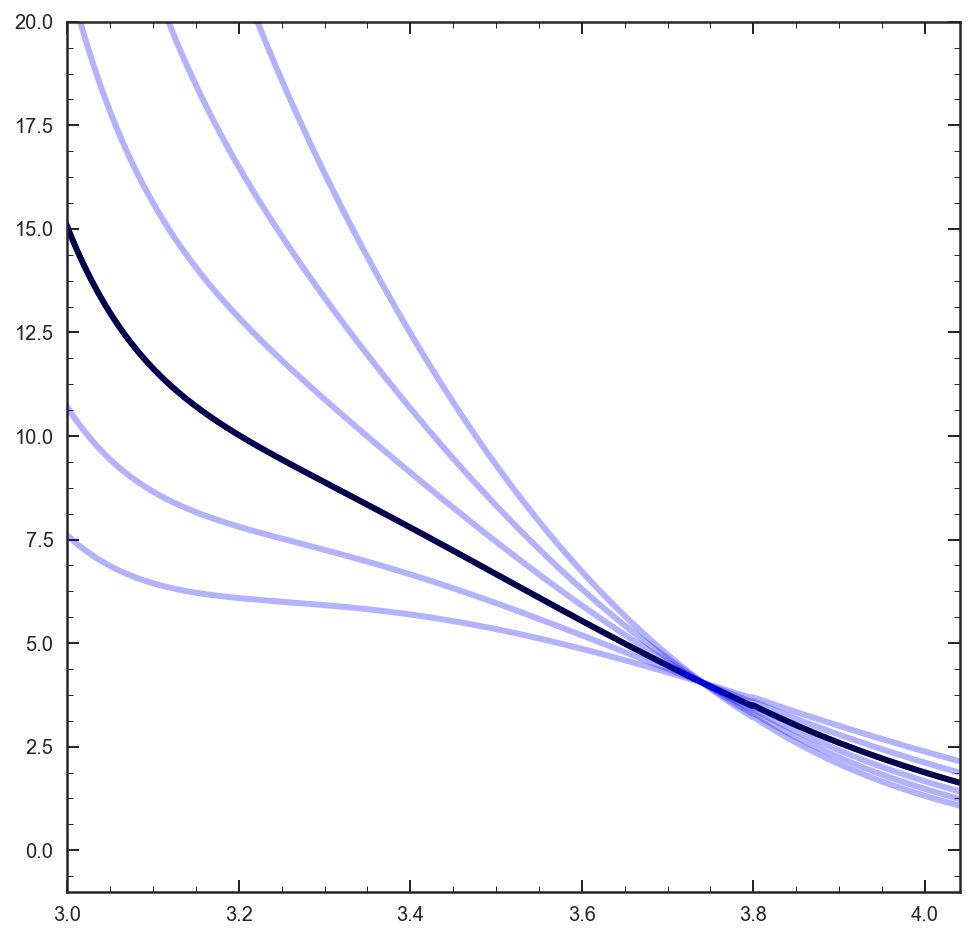

In [63]:
plt.figure(figsize=[8,8])
plt.plot(np.log10(wave),ck,'k', linewidth=3)

for i in np.arange(-0.6,0.5,0.2):
    sk = S_k(wave,i)
    plt.plot(np.log10(wave),sk,'b', linewidth=3, alpha=0.3)
plt.xlim(np.log10(1000),np.log10(11000))
plt.ylim(-1,20)